# Mini Project: Transfer Learning with Keras

Transfer learning is a machine learning technique where a model trained on one task is used as a starting point to solve a different but related task. Instead of training a model from scratch, transfer learning leverages the knowledge learned from the source task and applies it to the target task. This approach is especially useful when the target task has limited data or computational resources.

In transfer learning, the pre-trained model, also known as the "base model" or "source model," is typically trained on a large dataset and a more general problem (e.g., image classification on ImageNet, a vast dataset with millions of labeled images). The knowledge learned by the base model in the form of feature representations and weights captures common patterns and features in the data.

To perform transfer learning, the following steps are commonly followed:

1. Pre-training: The base model is trained on a source task using a large dataset, which can take a considerable amount of time and computational resources.

2. Feature Extraction: After pre-training, the base model is used as a feature extractor. The last few layers (classifier layers) of the model are discarded, and the remaining layers (feature extraction layers) are retained. These layers serve as feature extractors, producing meaningful representations of the data.

3. Fine-tuning: The feature extraction layers and sometimes some of the earlier layers are connected to a new set of layers, often called the "classifier layers" or "task-specific layers." These layers are randomly initialized, and the model is trained on the target task with a smaller dataset. The weights of the base model can be frozen during fine-tuning, or they can be allowed to be updated with a lower learning rate to fine-tune the model for the target task.

Transfer learning has several benefits:

1. Reduced training time and resource requirements: Since the base model has already learned generic features, transfer learning can save time and resources compared to training a model from scratch.

2. Improved generalization: Transfer learning helps the model generalize better to the target task, especially when the target dataset is small and dissimilar from the source dataset.

3. Better performance: By starting from a model that is already trained on a large dataset, transfer learning can lead to better performance on the target task, especially in scenarios with limited data.

4. Effective feature extraction: The feature extraction layers of the pre-trained model can serve as powerful feature extractors for different tasks, even when the task domains differ.

Transfer learning is commonly used in various domains, including computer vision, natural language processing (NLP), and speech recognition, where pre-trained models are fine-tuned for specific applications like object detection, sentiment analysis, or speech-to-text.

In this mini-project you will perform fine-tuning using Keras with a pre-trained VGG16 model on the CIFAR-10 dataset.

First, import all the libraries you'll need.

In [1]:
# Execution note: to run this locally in the browser with GPU support, naviagate to the directory in WSL2 bash and run "jupyter-lab --no-browser"
# Personal notes for the future : Had to use "tensorflow[and-cuda] == 2.16.1" to get GPU support to work, there seem to be a lot of issues with the current release of 2.18 that haven't been resolved.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

2024-11-13 09:40:49.569616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731519649.584570   27814 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731519649.589016   27814 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 09:40:49.606119: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


The CIFAR-10 dataset is a widely used benchmark dataset in the field of computer vision and machine learning. It stands for the "Canadian Institute for Advanced Research 10" dataset. CIFAR-10 was created by researchers at the CIFAR institute and was originally introduced as part of the Neural Information Processing Systems (NIPS) 2009 competition.

The dataset consists of 60,000 color images, each of size 32x32 pixels, belonging to ten different classes. Each class contains 6,000 images. The ten classes in CIFAR-10 are:

1. Airplane
2. Automobile
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck

The images are evenly distributed across the classes, making CIFAR-10 a balanced dataset. The dataset is divided into two sets: a training set and a test set. The training set contains 50,000 images, while the test set contains the remaining 10,000 images.

CIFAR-10 is often used for tasks such as image classification, object recognition, and transfer learning experiments. The relatively small size of the images and the variety of classes make it a challenging dataset for training machine learning models, especially deep neural networks. It also serves as a good dataset for teaching and learning purposes due to its manageable size and straightforward class labels.

Here are your tasks:

1. Load the CIFAR-10 dataset after referencing the documentation [here](https://keras.io/api/datasets/cifar10/).
2. Normalize the pixel values so they're all in the range [0, 1].
3. Apply One Hot Encoding to the train and test labels using the [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) function.
4. Further split the training data into training and validation sets using [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Use only 10% of the data for validation.  

In [4]:
# Load the CIFAR-10 dataset
(X_train, y_train),(X_test, y_test) = cifar10.load_data()
assert X_train.shape == (50000, 32, 32, 3)
assert X_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)
print(X_train[0])
print(y_train[0:10])

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


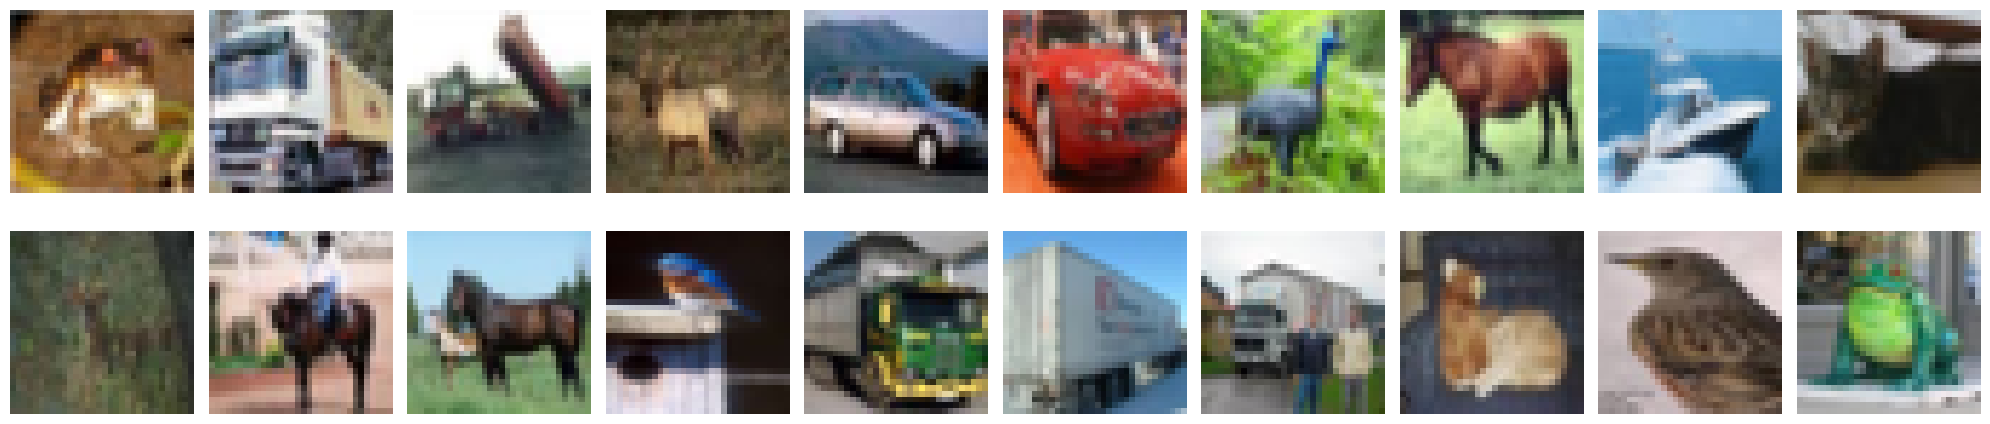

In [5]:
# A little bit of data exploration - let's look at some of the input data
def plotImages(a_image_array):
    fig, axes = plt.subplots(2, 10, figsize=(20,5))
    axes = axes.flatten()
    for img, ax in zip(a_image_array, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# show the first 20 images
plotImages(X_train[0:20])


In [6]:
# Normalize the pixel values to [0, 1]
X_train = X_train/255.0
X_test = X_test/255.0

In [7]:
# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [8]:
# Split the data into training and validation sets
X_train, X_pretest, y_train, y_pretest = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [9]:
# now we have onehotencoded training data, further split 90% from original
y_train[0:5]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

VGG16 (Visual Geometry Group 16) is a deep convolutional neural network architecture that was developed by the Visual Geometry Group at the University of Oxford. It was proposed by researchers Karen Simonyan and Andrew Zisserman in their paper titled "Very Deep Convolutional Networks for Large-Scale Image Recognition," which was presented at the International Conference on Learning Representations (ICLR) in 2015.

The VGG16 architecture gained significant popularity for its simplicity and effectiveness in image classification tasks. It was one of the pioneering models that demonstrated the power of deeper neural networks for visual recognition tasks.

Key characteristics of the VGG16 architecture:

1. Architecture: VGG16 consists of a total of 16 layers, hence the name "16." These layers are stacked one after another, forming a deep neural network.

2. Convolutional Layers: The main building blocks of VGG16 are the convolutional layers. It primarily uses 3x3 convolutional filters throughout the network, which allows it to capture local features effectively.

3. Max Pooling: After each set of convolutional layers, VGG16 applies max-pooling layers with 2x2 filters and stride 2, which halves the spatial dimensions (width and height) of the feature maps and reduces the number of parameters.

4. Fully Connected Layers: Towards the end of the network, VGG16 has fully connected layers that act as a classifier to make predictions based on the learned features.

5. Activation Function: The network uses the Rectified Linear Unit (ReLU) activation function for all hidden layers, which helps with faster convergence during training.

6. Number of Filters: The number of filters in each convolutional layer is relatively small compared to more recent architectures like ResNet or InceptionNet. However, stacking multiple layers allows VGG16 to learn complex hierarchical features.

7. Output Layer: The output layer consists of 1000 units, corresponding to 1000 ImageNet classes. VGG16 was originally trained on the large-scale ImageNet dataset, which contains millions of images from 1000 different classes.

VGG16 was instrumental in showing that increasing the depth of a neural network can significantly improve its performance on image recognition tasks. However, the main drawback of VGG16 is its high number of parameters, making it computationally expensive and memory-intensive to train. Despite this limitation, VGG16 remains an essential benchmark architecture and has paved the way for even deeper and more efficient models in the field of computer vision, such as ResNet, DenseNet, and EfficientNet.

Here are your tasks:

1. Load [VGG16](https://keras.io/api/applications/vgg/#vgg16-function) as a base model. Make sure to exclude the top layer.
2. Freeze all the layers in the base model. We'll be using these weights as a feature extraction layer to forward to layers that are trainable.

In [10]:
# Load the pre-trained VGG16 model (excluding the top classifier)
# also tried "weights='imagenet'," but got about the same results
vgg = VGG16(include_top=False, input_shape=(32, 32, 3))

I0000 00:00:1731519655.089647   27814 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9536 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


In [11]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Freeze the layers in the base model (weights and biases)
for layer in vgg.layers:
    layer.trainable = False

Now, we'll add some trainable layers to the base model.

1. Using the base model, add a [GlobalAveragePooling2D](https://keras.io/api/layers/pooling_layers/global_average_pooling2d/) layer, followed by a [Dense](https://keras.io/api/layers/core_layers/dense/) layer of length 256 with ReLU activation. Finally, add a classification layer with 10 units, corresponding to the 10 CIFAR-10 classes, with softmax activation.
2. Create a Keras [Model](https://keras.io/api/models/model/) that takes in approproate inputs and outputs.

In [13]:
# Add a global average pooling layer
x = GlobalAveragePooling2D()(vgg.output)

In [14]:
# Add a fully connected layer with 256 units and ReLU activation
# x = Dense(256, activation='relu')(global_layer)
# this change of 1 FC layer w/ 256 to 2 FC layers w/ 128 & 64 yielded very marginal improvements:
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

In [15]:
# Add the final classification layer with 10 units (for CIFAR-10 classes) and softmax activation
output_layer = Dense(units=10, activation='softmax')(x)

In [16]:
# Create the fine-tuned model
model = Model(inputs=vgg.input, outputs=output_layer)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,789,258 (56.42 MB)

 Trainable params: 74,570 (291.29 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

With your model complete it's time to train it and assess its performance.

1. Compile your model using an appropriate loss function. Feel free to play around with the optimizer, but a good starting optimizer might be Adam with a learning rate of 0.001.
2. Fit your model on the training data. Use the validation data to print the accuracy for each epoch. Try training for 10 epochs. Note, training can take a few hours so go ahead and grab a cup of coffee.

**Optional**: See if you can implement an [Early Stopping](https://keras.io/api/callbacks/early_stopping/) criteria as a callback function.

In [17]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Train the model
initial_epochs = 10
history = model.fit(x=X_train, y=y_train, validation_data=(X_pretest, y_pretest), epochs=initial_epochs, verbose=2)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

print(f'Preliminary accuracy: {model.history.history.get("accuracy")[-1]}')

Epoch 1/10


I0000 00:00:1731519658.960761   27897 service.cc:148] XLA service 0x7f282800eb70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731519658.960824   27897 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-11-13 09:40:58.989640: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731519659.158659   27897 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1731519661.149957   27897 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1407/1407 - 10s - 7ms/step - accuracy: 0.1540 - loss: 2.2630 - val_accuracy: 0.2474 - val_loss: 2.1664
Epoch 2/10
1407/1407 - 4s - 3ms/step - accuracy: 0.3089 - loss: 2.0857 - val_accuracy: 0.3500 - val_loss: 1.9984
Epoch 3/10
1407/1407 - 4s - 3ms/step - accuracy: 0.3727 - loss: 1.9299 - val_accuracy: 0.3872 - val_loss: 1.8585
Epoch 4/10
1407/1407 - 4s - 3ms/step - accuracy: 0.4076 - loss: 1.8034 - val_accuracy: 0.4170 - val_loss: 1.7467
Epoch 5/10
1407/1407 - 2s - 2ms/step - accuracy: 0.4369 - loss: 1.7051 - val_accuracy: 0.4434 - val_loss: 1.6631
Epoch 6/10
1407/1407 - 4s - 3ms/step - accuracy: 0.4553 - loss: 1.6339 - val_accuracy: 0.4536 - val_loss: 1.6057
Epoch 7/10
1407/1407 - 4s - 3ms/step - accuracy: 0.4700 - loss: 1.5815 - val_accuracy: 0.4648 - val_loss: 1.5603
Epoch 8/10
1407/1407 - 4s - 3ms/step - accuracy: 0.4793 - loss: 1.5406 - val_accuracy: 0.4726 - val_loss: 1.5251
Epoch 9/10
1407/1407 - 4s - 3ms/step - accuracy: 0.4886 - loss: 1.5075 - val_accuracy: 0.4820 - val_loss: 

With your model trained, it's time to assess how well it performs on the test data.

1. Use your trained model to calculate the accuracy on the test set. Is the model performance better than random?
2. Experiment! See if you can tweak your model to improve performance.  

In [19]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss={test_loss:.4f}, Test Accuracy={test_acc:.4f}")
print("Looks like it's better than random, but not by much after 10 epochs. A smaller learning rate and more epochs keeps improving, and prevents overfitting.")
#predictions = model.predict(x=y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4865 - loss: 1.4820
Test Loss=1.4847, Test Accuracy=0.4923
Looks like it's better than random, but not by much after 10 epochs. A smaller learning rate and more epochs keeps improving, and prevents overfitting.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


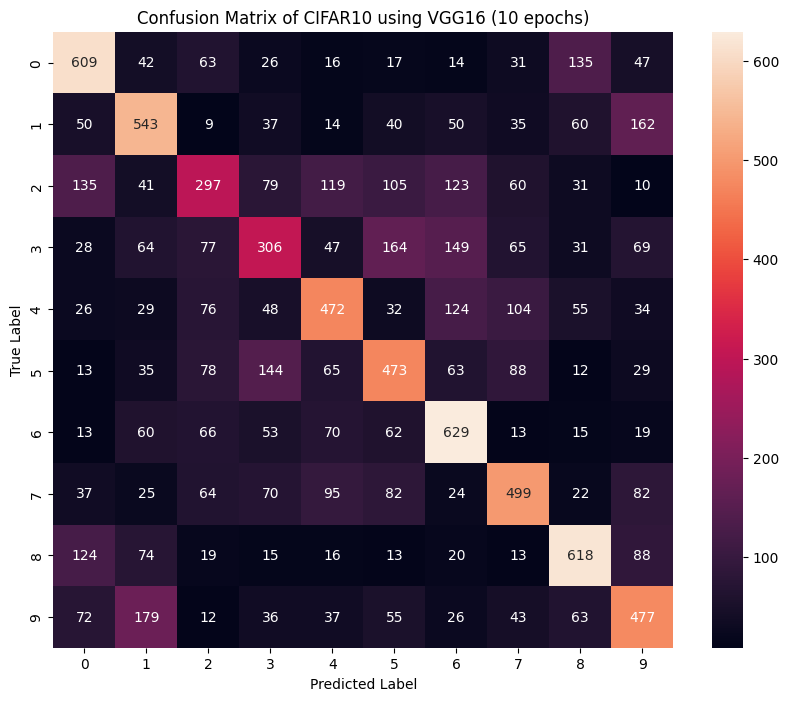

In [20]:
# Taking a look at the confusion matrix as well
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix of CIFAR10 using VGG16 ({initial_epochs} epochs)")
plt.show()

In [21]:
# Train the model another 90 epochs and see how much it improves
fine_tune_epochs = 140
history = model.fit(x=X_train, y=y_train, validation_data=(X_pretest, y_pretest), epochs=fine_tune_epochs, verbose=2)
print(f'Preliminary accuracy: {model.history.history.get("accuracy")[-1]}')

Epoch 1/140
1407/1407 - 3s - 2ms/step - accuracy: 0.5041 - loss: 1.4553 - val_accuracy: 0.4972 - val_loss: 1.4497
Epoch 2/140
1407/1407 - 4s - 3ms/step - accuracy: 0.5103 - loss: 1.4345 - val_accuracy: 0.5010 - val_loss: 1.4309
Epoch 3/140
1407/1407 - 4s - 3ms/step - accuracy: 0.5152 - loss: 1.4162 - val_accuracy: 0.5020 - val_loss: 1.4149
Epoch 4/140
1407/1407 - 4s - 3ms/step - accuracy: 0.5207 - loss: 1.4000 - val_accuracy: 0.5090 - val_loss: 1.4009
Epoch 5/140
1407/1407 - 4s - 3ms/step - accuracy: 0.5248 - loss: 1.3854 - val_accuracy: 0.5128 - val_loss: 1.3877
Epoch 6/140
1407/1407 - 4s - 3ms/step - accuracy: 0.5294 - loss: 1.3721 - val_accuracy: 0.5168 - val_loss: 1.3757
Epoch 7/140
1407/1407 - 4s - 3ms/step - accuracy: 0.5326 - loss: 1.3600 - val_accuracy: 0.5244 - val_loss: 1.3659
Epoch 8/140
1407/1407 - 4s - 3ms/step - accuracy: 0.5363 - loss: 1.3490 - val_accuracy: 0.5236 - val_loss: 1.3566
Epoch 9/140
1407/1407 - 2s - 2ms/step - accuracy: 0.5390 - loss: 1.3389 - val_accuracy: 

In [22]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss={test_loss:.4f}, Test Accuracy={test_acc:.4f}")
#predictions = model.predict(x=y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5935 - loss: 1.1427
Test Loss=1.1458, Test Accuracy=0.5993


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


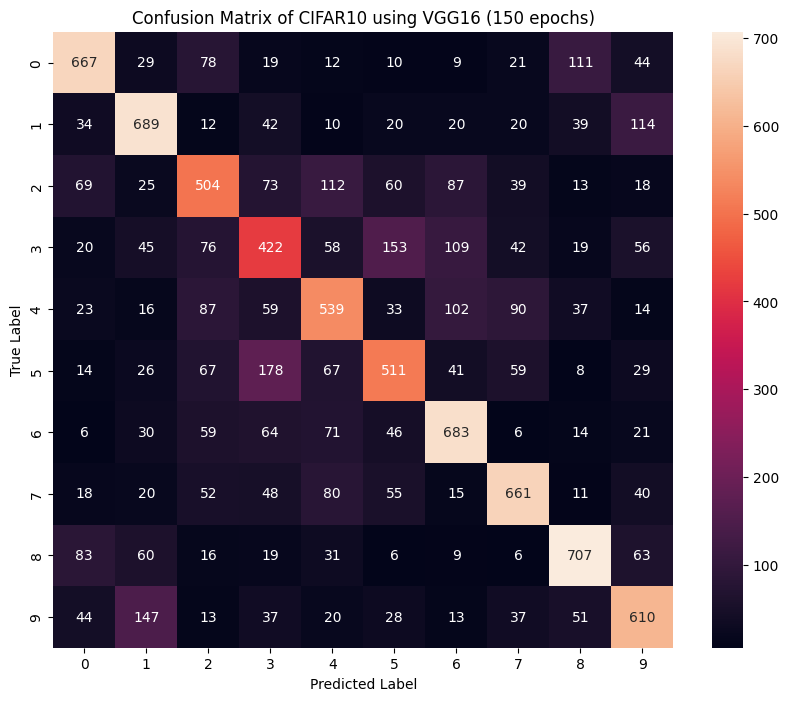

In [23]:
# Taking a look at the confusion matrix as well
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix of CIFAR10 using VGG16 ({initial_epochs + fine_tune_epochs} epochs)")
plt.show()

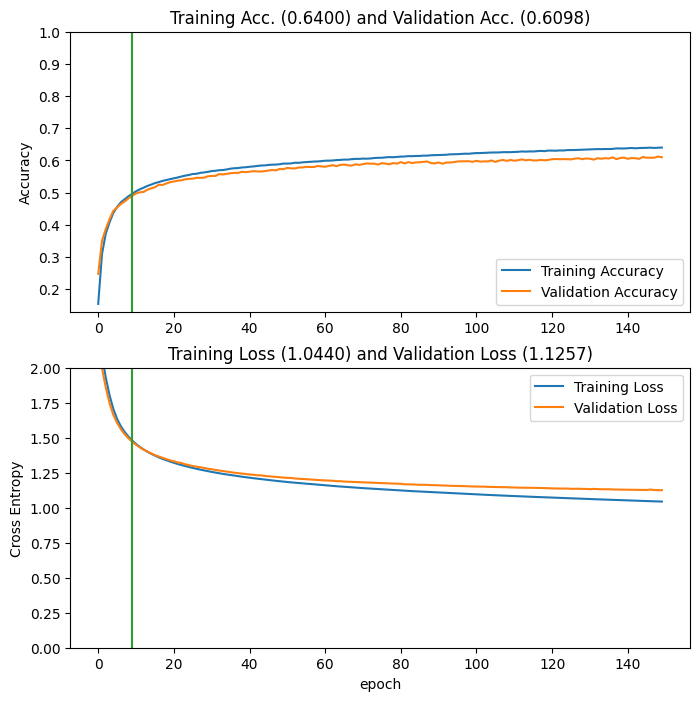

In [24]:
# Evaluate Loss and Accuracy, from https://www.tensorflow.org/tutorials/images/transfer_learning
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']

loss += history.history['loss']
val_loss += history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="First pass")
plt.title(f'Training Acc. ({history.history['accuracy'][-1]:0.4f}) and Validation Acc. ({history.history['val_accuracy'][-1]:0.4f})')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="First pass")
plt.title(f'Training Loss ({history.history['loss'][-1]:0.4f}) and Validation Loss ({history.history['val_loss'][-1]:0.4f})')
plt.xlabel('epoch')
plt.show()


In [40]:
###### Load some rnaomdly chosen test images from google
# Note: CIFAR10 has  10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks
import pandas as pd

np.set_printoptions(linewidth=300, precision=4, suppress=True)
pd.options.display.float_format = '{:.3f}'.format

# original class names from Wikipedia, but we'll get the specific ones from the file structure when loading the images
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# this will create a tf.data.Dataset object, with a tuple (images, labels)
#     where images has shape (batch_size, image_size[0], image_size[1], num_channels)
#     and labels has shape of a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index

sample_path = './sample_test_images'
sample_dataset = tf.keras.utils.image_dataset_from_directory(
    sample_path, 
    image_size=(32,32),        # automatically resizes to match CIFAR10 training data input size
    labels='inferred',         # gets class names from directory names
    label_mode='categorical',
    batch_size=49,             # individual samples for real-time analysis from a camera, or bigger batches from folders are more efficient
    shuffle=False              # always load in same alphanumeric order
) 
print(sample_dataset)

# get the class names and other metadata before transforming
sample_class_names = sample_dataset.class_names
sample_file_names = sample_dataset.file_paths

# rescale the RGB data from 0 to 1
def normalizeRGB( a_image, a_label):
    image_it = tf.cast(a_image/255.0, tf.float32)
    return image_it, a_label
    
norm_sample_dataset = sample_dataset.map(normalizeRGB)

# this is only one batch chunk; but since we only have 49 test images, do it all in one batch
image_batch, label_batch = norm_sample_dataset.as_numpy_iterator().next()

sample_pred = model.predict_on_batch(image_batch)
sample_pred_indices = np.argmax(sample_pred,axis=1)
sample_true_indices = np.argmax(label_batch, axis=1)

print(f"sample predictions: {sample_pred_indices}; batch size = {len(sample_pred)}")
print(f"sample labels:      {sample_true_indices}")

# Create a DataFrame to more easily visualize the prediction probabilities
sample_pred = model.predict(norm_sample_dataset)

sample_pred_df = pd.DataFrame(sample_pred, columns=sample_class_names) # index=sample_dataset.labels
sample_pred_df['true labels'] = sample_true_indices
sample_pred_df = sample_pred_df.style.highlight_max(props='color:blue;', subset=sample_pred_df.columns.drop('true labels'), axis=1)
sample_pred_df



Found 49 files belonging to 10 classes.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
sample predictions: [1 8 0 5 7 0 0 0 0 0 0 7 9 9 1 9 1 6 2 0 2 0 4 0 2 0 3 6 6 7 6 4 4 7 2 6 6 4 6 6 4 7 8 9 7 6 9 4 1]; batch size = 49
sample labels:      [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 4 4 4 4 5 6 6 6 6 6 6 7 7 8 8 9 9 9 9 9]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck,true labels
0,0.035651,0.620932,0.000953,0.019026,0.000120,0.013744,0.026844,0.000068,0.016149,0.266513,0
1,0.129401,0.010727,0.000482,0.001624,0.011256,0.001355,0.000414,0.001024,0.793643,0.050073,0
2,0.926004,0.009562,0.019665,0.003909,0.005707,0.001701,0.000185,0.006117,0.023202,0.003948,0
3,0.353003,0.011106,0.146231,0.049062,0.045256,0.366043,0.002069,0.016941,0.001272,0.009017,0
4,0.196353,0.000240,0.034133,0.020416,0.103694,0.076219,0.002179,0.564656,0.000295,0.001814,0
5,0.673807,0.099647,0.004508,0.005037,0.029537,0.004169,0.000315,0.084623,0.037450,0.060906,0
6,0.819926,0.000031,0.156499,0.001056,0.018603,0.000469,0.000497,0.000473,0.002436,0.000010,0
7,0.788205,0.000937,0.035253,0.004583,0.048218,0.003303,0.000134,0.117566,0.000308,0.001494,0
8,0.991710,0.000252,0.002338,0.000528,0.000204,0.000266,0.003314,0.000005,0.001100,0.000283,0
9,0.329423,0.015257,0.268016,0.010030,0.070275,0.018813,0.018126,0.001234,0.221557,0.047269,0


In [26]:
# Consolidate the results to see which images were wrongly classified
#class_labels = list(sample_data.class_indices.keys())

true_labels = []
for idx, labels in sample_dataset:
    true_labels.extend(np.argmax(labels, axis=1))

pred_class_indices = np.argmax(sample_pred, axis=1)
pred_class_names = [sample_class_names[i] for i in pred_class_indices]
true_class_names = [sample_class_names[i] for i in true_labels]

results_df = pd.DataFrame({
    'Predicted Label' : pred_class_names,
    'True Label' : true_class_names,
    'Predicted Class Index' : pred_class_indices,
    'True Class Index' : sample_true_indices
})
results_df

2024-11-13 09:50:29.735114: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,Predicted Label,True Label,Predicted Class Index,True Class Index
0,automobile,airplane,1,0
1,ship,airplane,8,0
2,airplane,airplane,0,0
3,dog,airplane,5,0
4,horse,airplane,7,0
5,airplane,airplane,0,0
6,airplane,airplane,0,0
7,airplane,airplane,0,0
8,airplane,airplane,0,0
9,airplane,airplane,0,0


Misclassed indices: [ 0  1  3  4 11 12 13 15 17 19 21 22 23 24 25 27 28 29 30 33 34 37 40 43 44 45 47 48], type: <class 'numpy.ndarray'>
Misclassed Labels Indicies: [0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 5, 6, 6, 7, 8, 9, 9, 9, 9]; length: 28;
Predicted Labels Indicies : [1, 8, 5, 7, 7, 9, 9, 9, 6, 0, 0, 4, 0, 2, 0, 6, 6, 7, 6, 7, 2, 4, 4, 9, 7, 6, 4, 1]; length: 28;


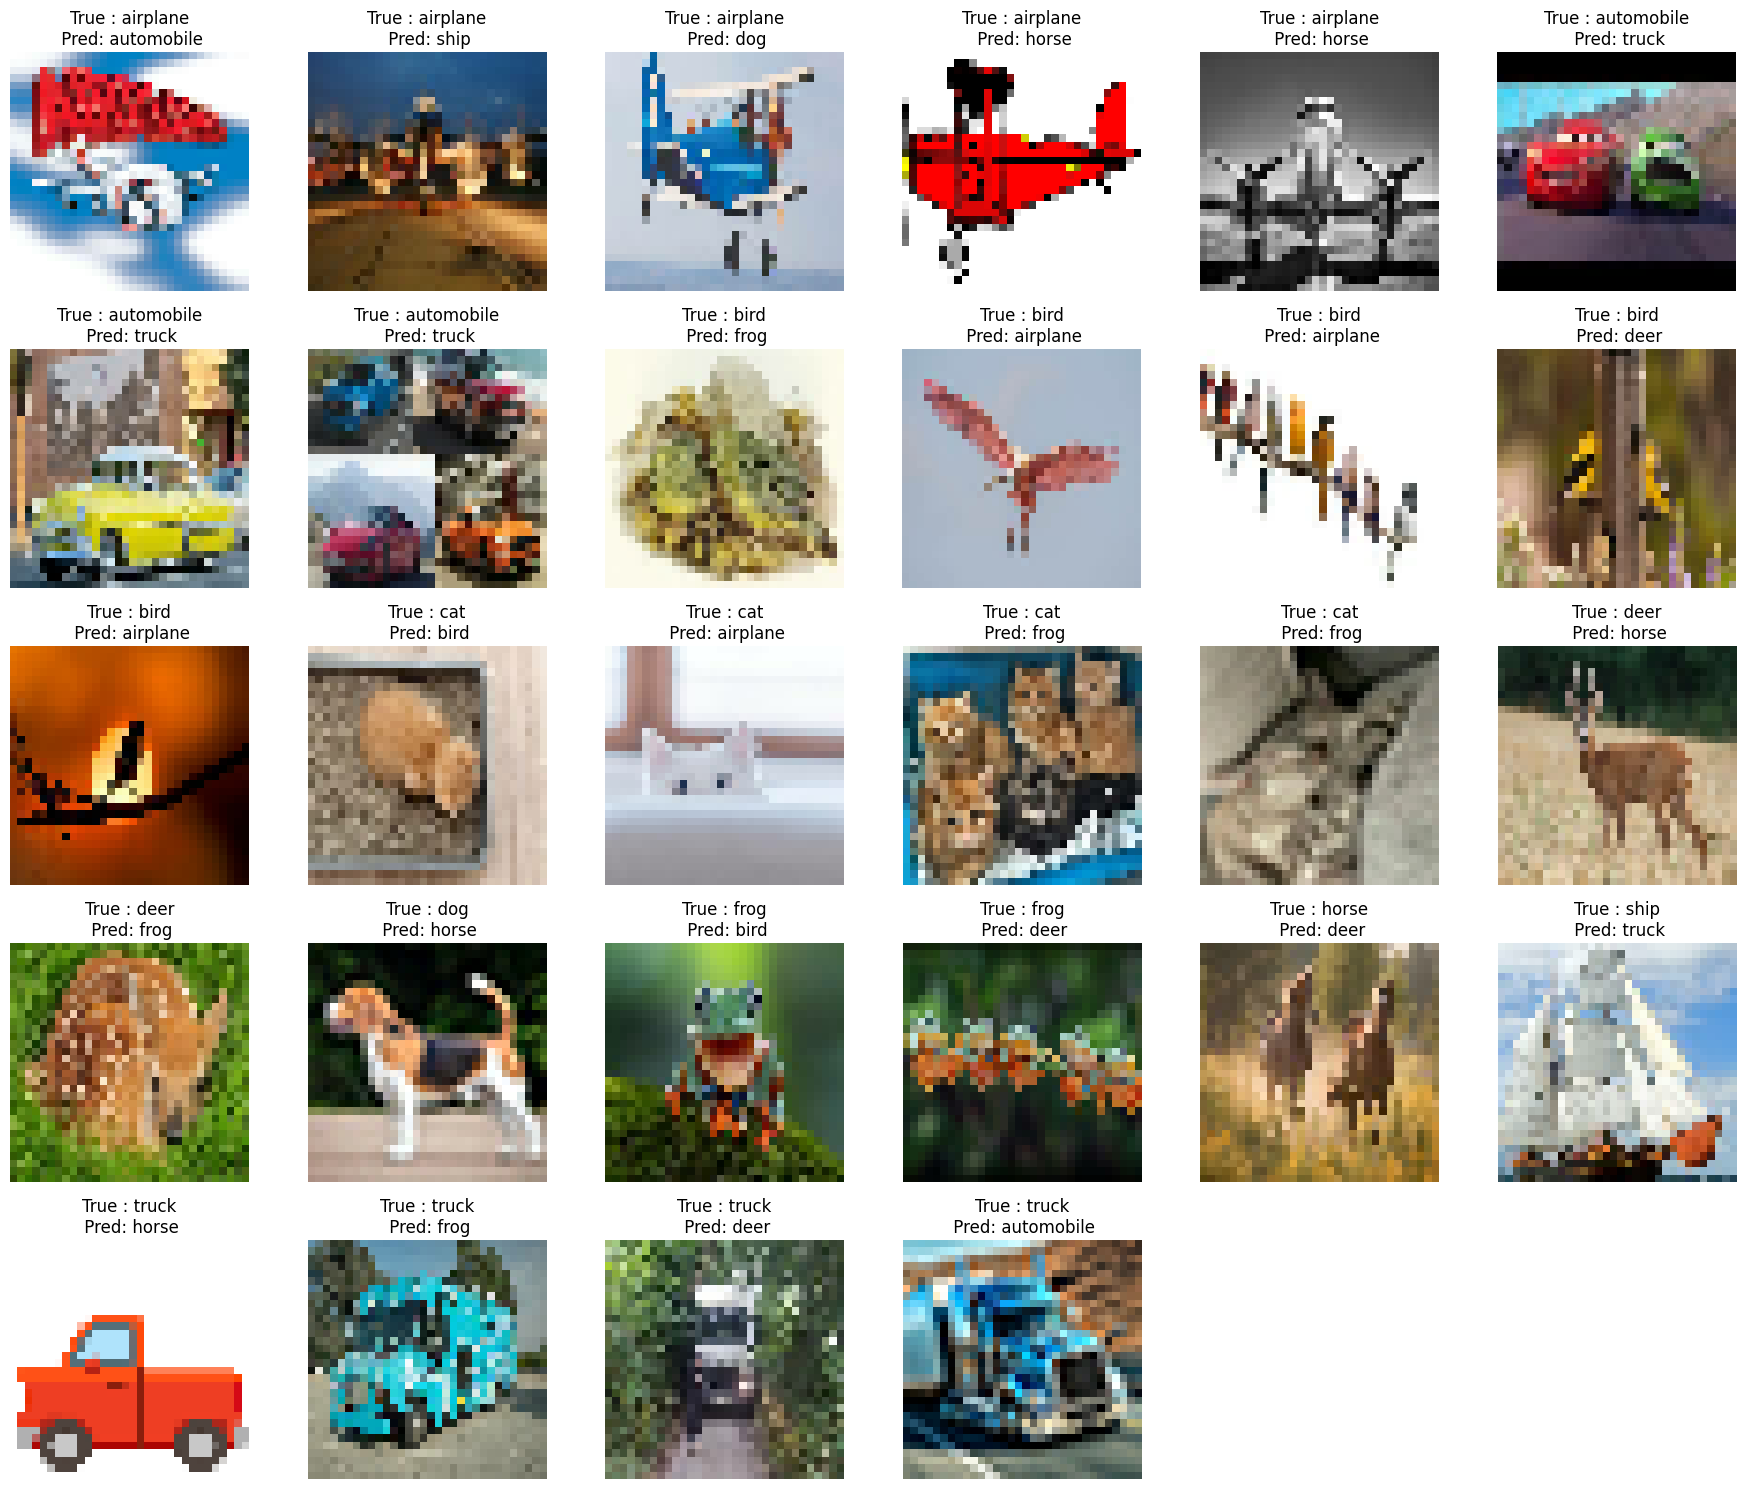

In [27]:
# Show the images that were incorrectly labeled

misclassed_indices = np.where(pred_class_indices != sample_true_indices)[0]
print(f"Misclassed indices: {misclassed_indices}, type: {type(misclassed_indices)}")
#plotImages(sample_data[misclassed_indices[1]][0])

extracted_images = []
extracted_true_label_indices = []
extracted_pred_label_indices = []

# we can't directly index into tf.data.Dataset, so have to iterate over it and extract the misclassed items
# also have the unbatch it, otherwise enumerate returns the entire batch
for i, (img, label) in enumerate(sample_dataset.unbatch()):
    if i in misclassed_indices:
        extracted_images.append(img.numpy())
        extracted_true_label_indices.append(np.argmax(label.numpy()))
        extracted_pred_label_indices.append(pred_class_indices[i])
    if len(extracted_images) == len(misclassed_indices):
        break

print(f"Misclassed Labels Indicies: {extracted_true_label_indices}; length: {len(extracted_true_label_indices)};")
print(f"Predicted Labels Indicies : {extracted_pred_label_indices}; length: {len(extracted_pred_label_indices)};")

n_cols = 6
n_rows = (len(extracted_images) + n_cols -1) // n_cols
plt.figure(figsize=(n_cols * 3, n_rows * 3))

for i, (img, true_label_idx, pred_label_idx) in enumerate(zip(extracted_images, extracted_true_label_indices, extracted_pred_label_indices)):
    # print(f"i: {i}; true label: {true_label_idx}, pred label: {pred_label_idx}")
    plt.subplot(n_rows, n_cols, i+1) # position in the grid
    plt.imshow(img.astype('uint8')) # assuming RGB format
    plt.title(f"True : {sample_class_names[true_label_idx]}\n Pred: {sample_class_names[pred_label_idx]}")
    plt.axis('off')


plt.tight_layout()
plt.show()
